<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/DCNNCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1000
CLASSIFICATION_EPOCHS = 1000
COLOURISATION_EPOCHS = 1000
LOAD_COLOURISATION_MODEL = False
INPUT_IMAGE = 10

# Import Statements

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/DeterministicConvNetCifar10/"

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

170500096/170498071 [==============================] - 11s 0us/step


# Convert Classification Images to Grayscale

In [0]:
train_gray_images = tf.image.rgb_to_grayscale(train_images[:IMAGE_COUNT])
test_gray_images = tf.image.rgb_to_grayscale(test_images[:IMAGE_COUNT])

# Load the Classification Model

In [5]:
model_dir = os.path.dirname(base_dir + "classification.h5")

json_file = open(base_dir + "classification.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
classification_model = models.model_from_json(loaded_model_json)
classification_model.load_weights(base_dir + "classification.h5", by_name=False)

opt = optimizers.SGD(lr=0.001, momentum=0.9)
classification_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print("Loaded model from disk")

Loaded model from disk


# Classification Results

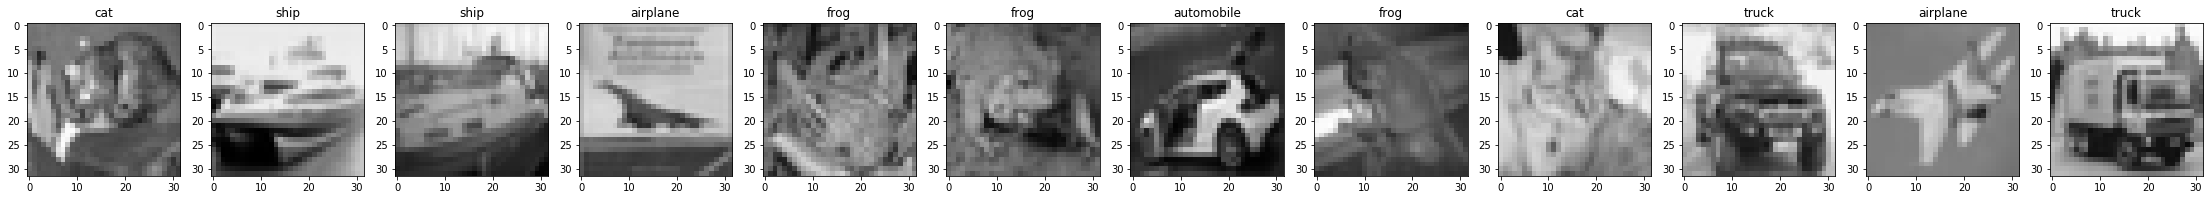

In [6]:
image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

output_count = 12

fig = plt.figure(figsize=(39,39))
for i in range(output_count):
  result = classification_model.predict_classes(tf.expand_dims(test_gray_images[i], 0))
  fig.add_subplot(1,output_count,i+1)
  plt.title(image_labels[int(result)])
  plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[i]))

# Evaluate Image Class

Predicted image class: [0] - airplane


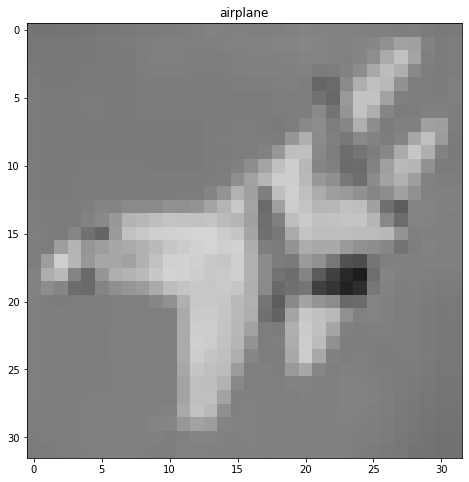

In [7]:
result = classification_model.predict_classes(tf.expand_dims(test_gray_images[INPUT_IMAGE], 0))
print("Predicted image class:", result, "-", image_labels[int(result)])
fig = plt.figure(figsize=(8,8))
plt.title(image_labels[int(result)])
plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[INPUT_IMAGE]))

class_train_indices = np.argwhere(train_labels == result)
class_train_images = train_images[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == result)
class_test_images = test_images[class_test_indices[:,0]]

# Convert Colourisation Images to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(class_train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(class_test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

# Create the Colourisation CNN

In [0]:
# Conv2D(filters (number of output filters)
#           - determine parameter number
#        kernel_size (size of convolution window)
#        activation (activation function to use)
#        padding ("valid" or "same")
#        strides (strides of the convolution along the height and width)
#           - strides greater than 1 will downsample
#        input_shape (only used on the first layer of the model))
#
# UpSampling2D(size (upsampling factors for rows and columns))

#https://github.com/emilwallner/Coloring-greyscale-images

# For an odd-sized filter, all the previous layer pixels would be symmetrically 
# around the output pixel. If you think of convolution as an interpolation from 
# the given pixels to a center pixel, we cannot interpolate to a center pixel 
# using an even-sized filter.

# Try a shallower model with the same # of parameters
# Try leaky relu
# Investgiate VAEs
# def create_colourisation_model():
#   model = models.Sequential()
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Conv2D(128, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Conv2D(2, (3, 3), activation='tanh', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
#   model.compile(optimizer=opt, loss='mse')
#   return model

# def create_colourisation_model():
#   model = models.Sequential()
#   model.add(layers.Conv2D(8, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(128, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(128, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.Dropout(0.2))
#   model.add(layers.Conv2D(16, (3, 3), activation='relu', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(2, (3, 3), activation='tanh', bias_regularizer=regularizers.l1(0.00001), padding='same'))
#   opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
#   model.compile(optimizer=opt, loss='mse')
#   return model

def create_colourisation_model():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), bias_regularizer=regularizers.l1(0.00001), input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(16, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(16, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', bias_regularizer=regularizers.l1(0.00001), padding='same'))
  opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
  model.compile(optimizer=opt, loss='mse')
  return model

if not (LOAD_COLOURISATION_MODEL):
  create_colourisation_model().summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         80        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 32)          0


# Train the Colourisation Model

In [0]:
# fit(x (input data)
#     y (target data)
#     batch_size (samples per gradient update)
#        - smaller batch size = more stochastic
#     epochs (epochs to train the model))

#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset

def train_image_loader(x_train, y_train, batch_size):
  datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.5, 1.0), zoom_range=[0.5, 1.5])
  datagen.fit(x_train)
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      print("\ncount: ", count, " - x_batch.shape: ", x_batch.shape, " - y_batch.shape: ", y_batch.shape)
      yield (x_batch, y_batch)  

def test_image_loader(x_test, y_test, batch_size):
  datagen = ImageDataGenerator()
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_test, y_test, batch_size=batch_size):
      yield (x_batch, y_batch)  

runtime_epochs = int(COLOURISATION_EPOCHS/4)
total_loss = []
total_val_loss = []
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_iterator = datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE)

if not (LOAD_COLOURISATION_MODEL):
  model = create_colourisation_model()
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE), verbose=1)
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  
  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/250
5/5 [==============================] - 3s 567ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 2/250
5/5 [==============================] - 2s 350ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 3/250
5/5 [==============================] - 2s 347ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 4/250
5/5 [==============================] - 2s 340ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/250
5/5 [==============================] - 2s 332ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/250
5/5 [==============================] - 2s 368ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 7/250
5/5 [==============================] - 2s 371ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/250
5/5 [==============================] - 2s 364ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 9/250
5/5 [==============================] - 2s 338ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 10/250
5/5 [==============================] - 2s 344ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 11/

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE), verbose=1)
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  
  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/250
5/5 [==============================] - 2s 442ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 2/250
5/5 [==============================] - 2s 347ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/250
5/5 [==============================] - 2s 343ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/250
5/5 [==============================] - 2s 360ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/250
5/5 [==============================] - 2s 350ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/250
5/5 [==============================] - 2s 355ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/250
5/5 [==============================] - 2s 361ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 8/250
5/5 [==============================] - 2s 381ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/250
5/5 [==============================] - 2s 366ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/250
5/5 [==============================] - 2s 359ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 11/

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE), verbose=1)
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))

  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/250
5/5 [==============================] - 2s 393ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 2/250
5/5 [==============================] - 2s 387ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 3/250
5/5 [==============================] - 2s 350ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/250
5/5 [==============================] - 2s 359ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 5/250
5/5 [==============================] - 2s 355ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 6/250
5/5 [==============================] - 2s 351ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/250
5/5 [==============================] - 2s 361ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/250
5/5 [==============================] - 2s 342ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/250
5/5 [==============================] - 2s 354ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/250
5/5 [==============================] - 2s 357ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 11/

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE), verbose=1)
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))

  model_json = model.to_json()
  with open(base_dir + "colourisation.json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights(base_dir + "colourisation.h5")
  print("Saved model to disk")

  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/250
5/5 [==============================] - 2s 407ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 2/250
5/5 [==============================] - 2s 344ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 3/250
5/5 [==============================] - 2s 351ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/250
5/5 [==============================] - 2s 358ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 5/250
5/5 [==============================] - 2s 388ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/250
5/5 [==============================] - 2s 374ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/250
5/5 [==============================] - 2s 364ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/250
5/5 [==============================] - 2s 353ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/250
5/5 [==============================] - 2s 353ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/250
5/5 [==============================] - 2s 345ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 11/

In [0]:
if(LOAD_COLOURISATION_MODEL):
  json_file = open(base_dir + "colourisation.json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = models.model_from_json(loaded_model_json)
  model.load_weights(base_dir + "colourisation.h5", by_name=False)
  model.compile(optimizer='rmsprop', loss='mse')

  print("Loaded model from disk")

# Colourisation Diagnostic Learning Curves

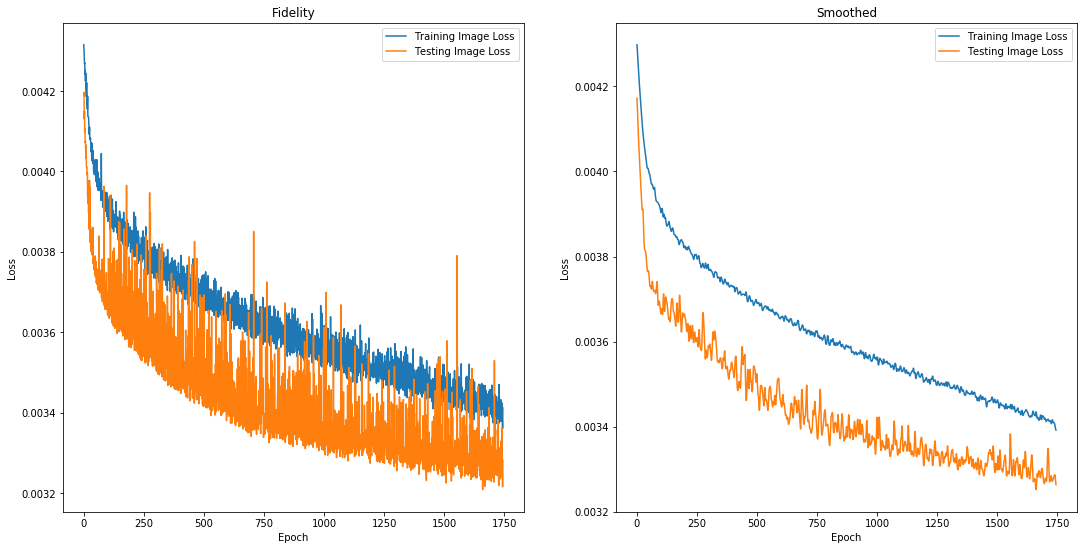

In [0]:
if not (LOAD_COLOURISATION_MODEL):
  fig = plt.figure(figsize=(38, 9))

  fig.add_subplot(1,4,1)
  plt.title("Fidelity")
  plt.plot(total_loss[5:], label="Training Image Loss")
  if not (LOAD_COLOURISATION_MODEL):
    plt.plot(total_val_loss[5:], label="Testing Image Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig("Fidelity.png")
  # files.download("Fidelity.png") 

  fig.add_subplot(1,4,2)
  plt.title("Smoothed")
  plt.plot(gaussian_filter1d(total_loss[5:], sigma=2), label="Training Image Loss")
  if not (LOAD_COLOURISATION_MODEL):
    plt.plot(gaussian_filter1d(total_val_loss[5:], sigma=2), label="Testing Image Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig("Smooted.png")
  # files.download("Smooted.png") 

# Training Results

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


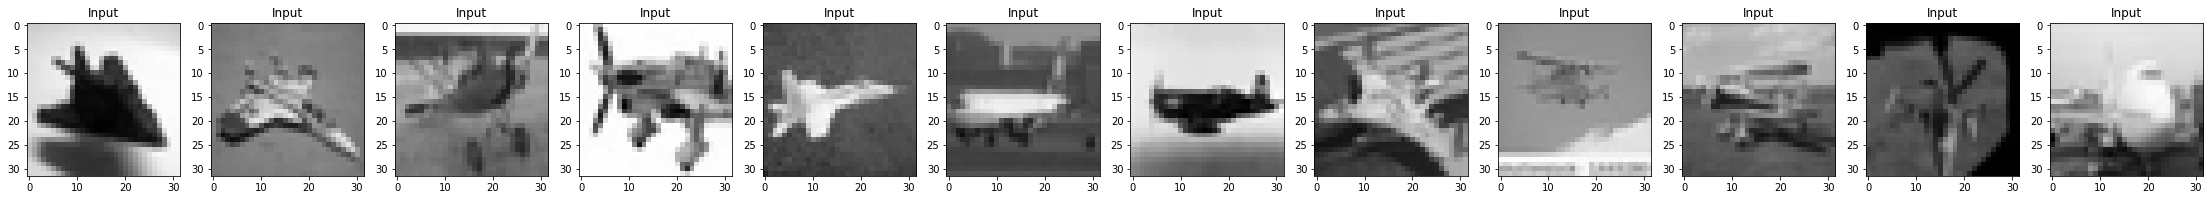

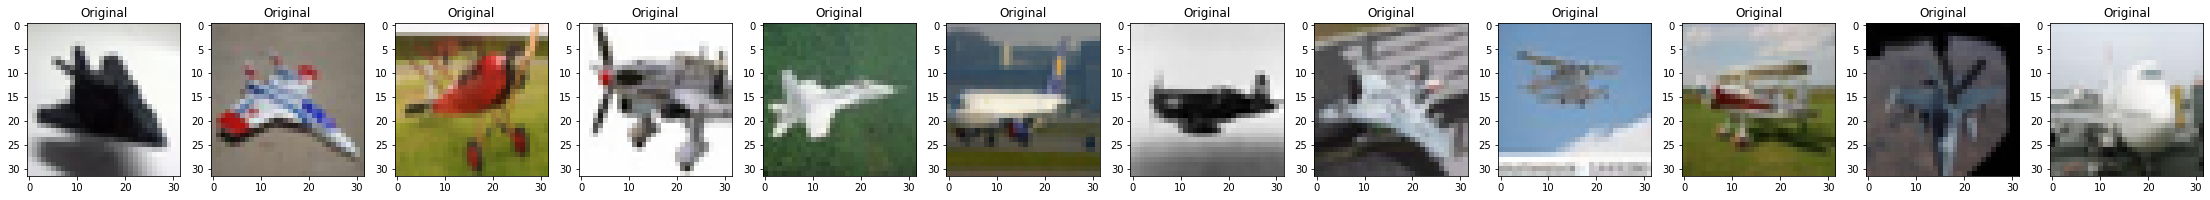

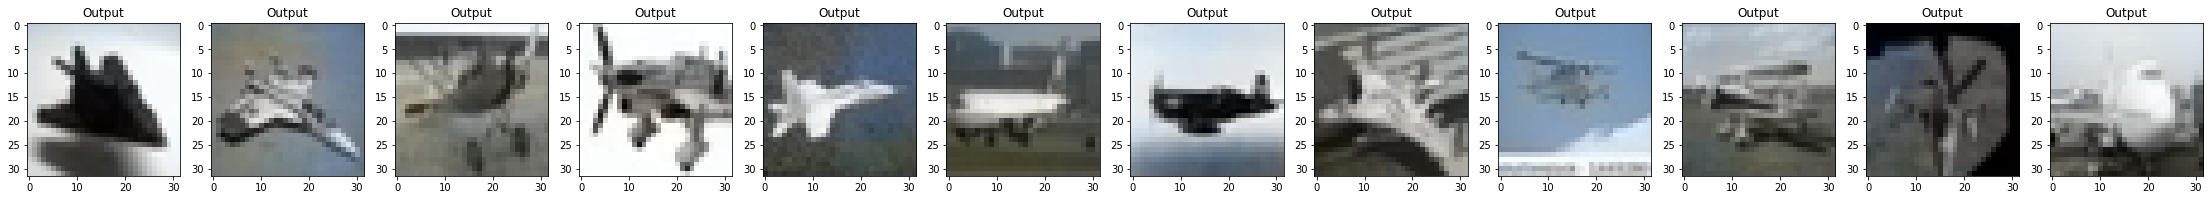

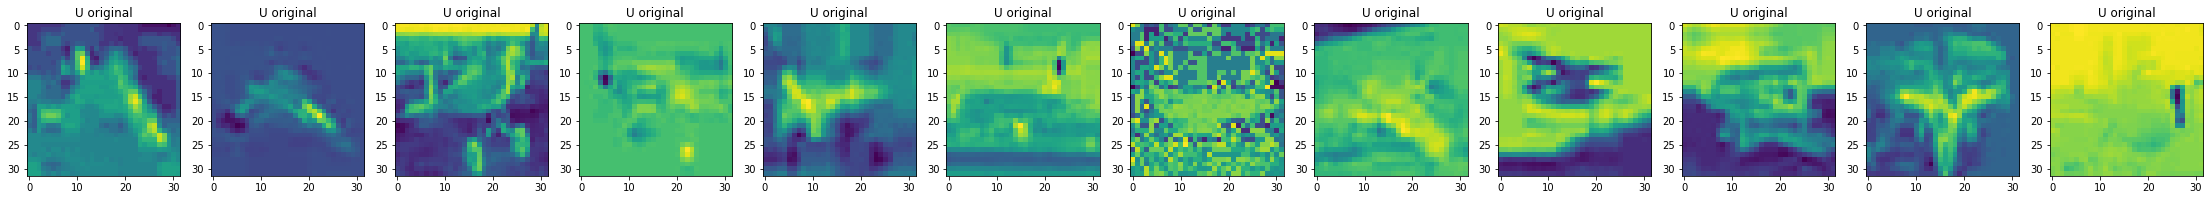

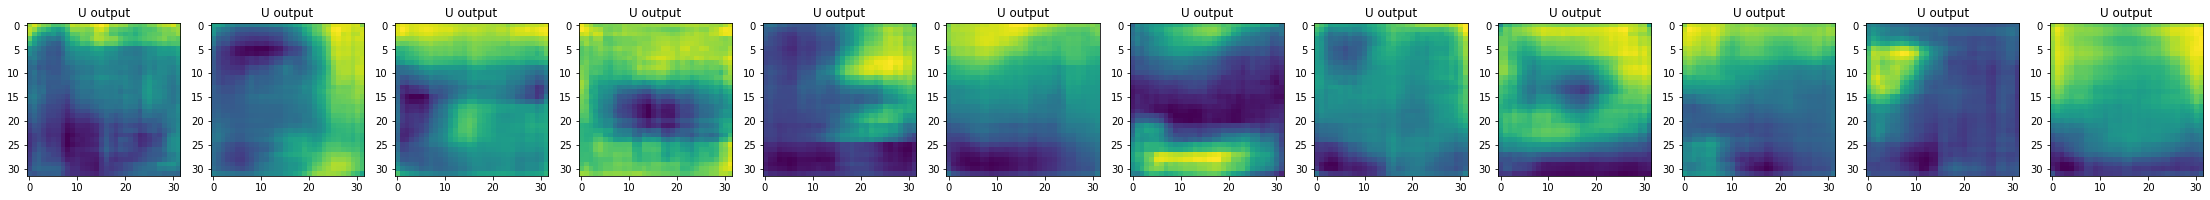

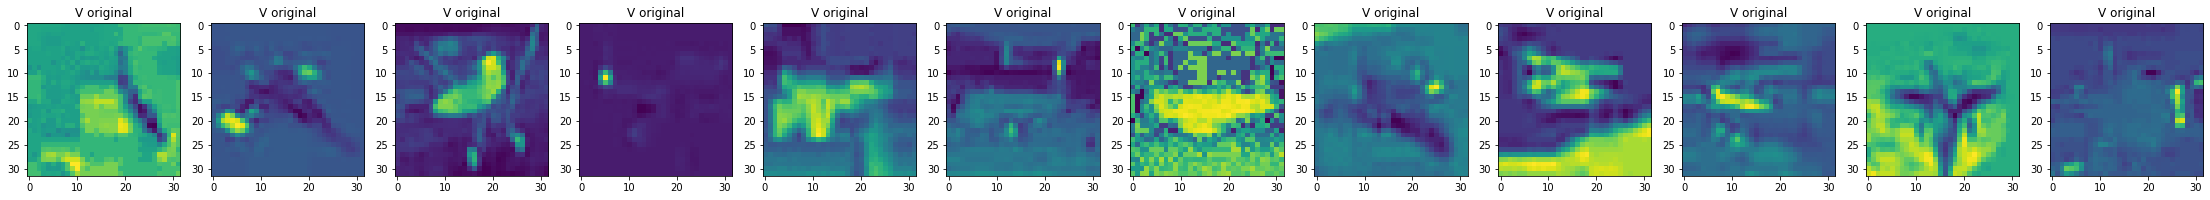

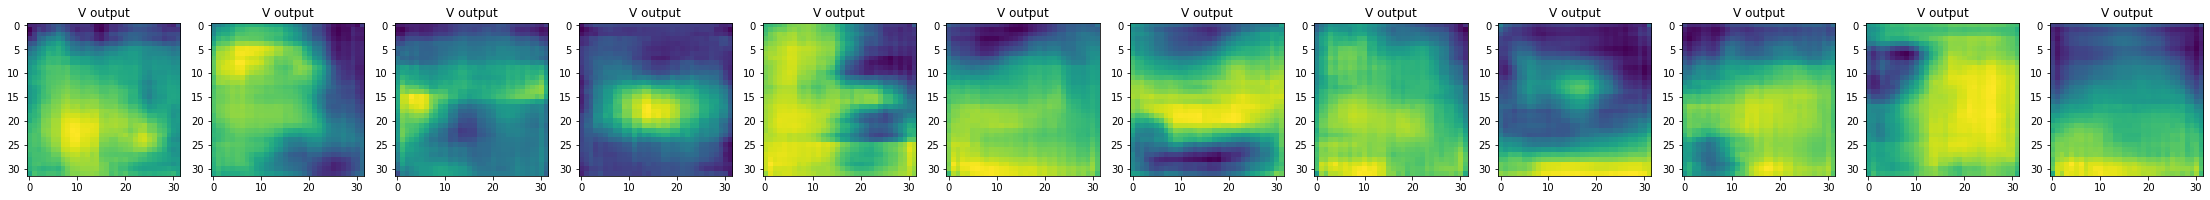

In [0]:
print(model.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = model.predict(train_y)
result = np.zeros((train_y.shape[0], 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


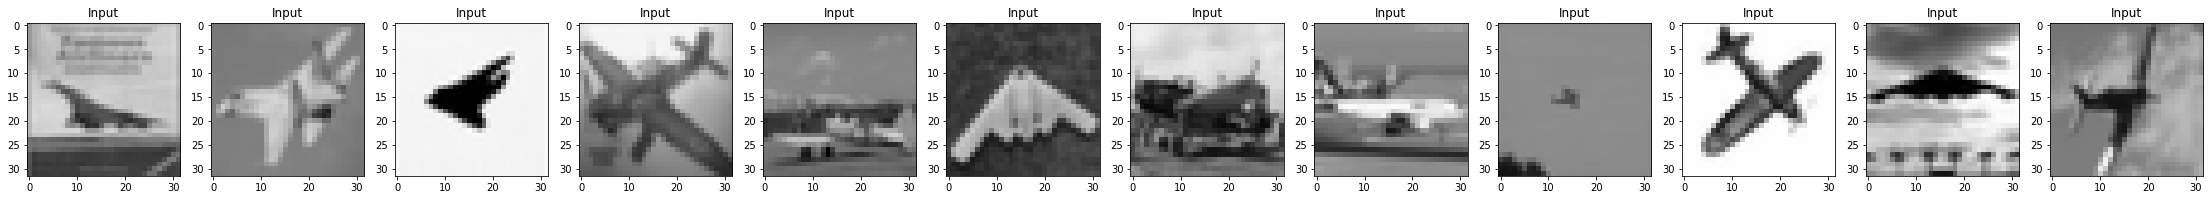

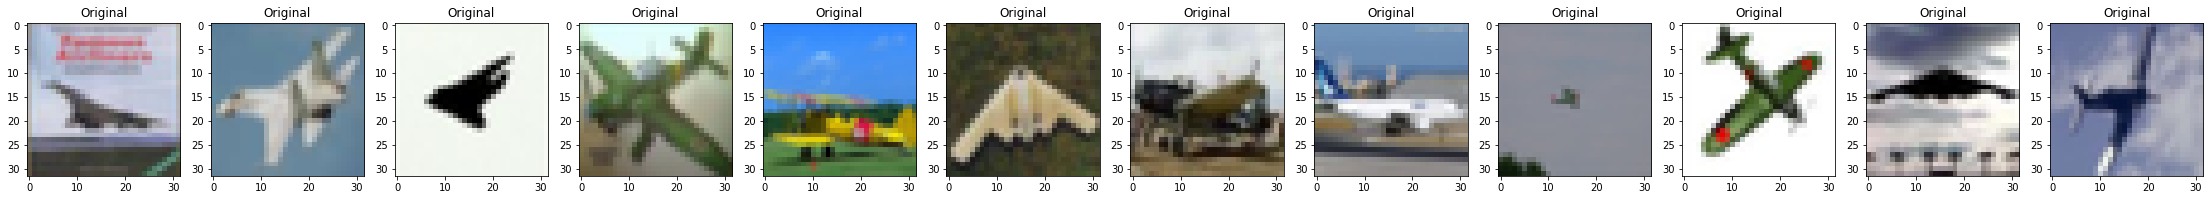

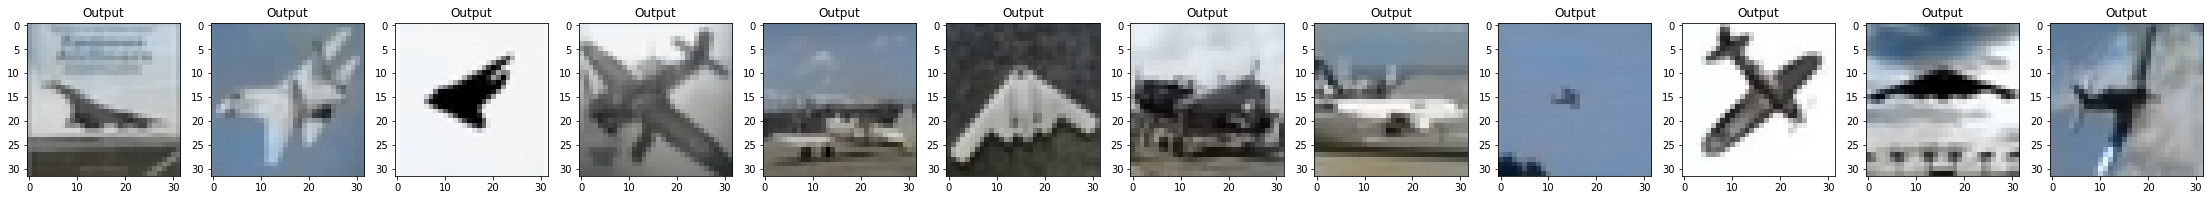

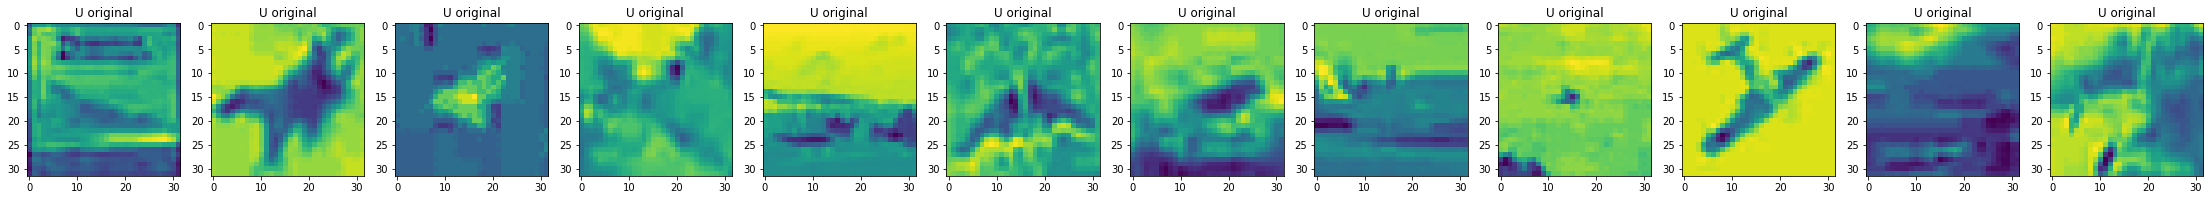

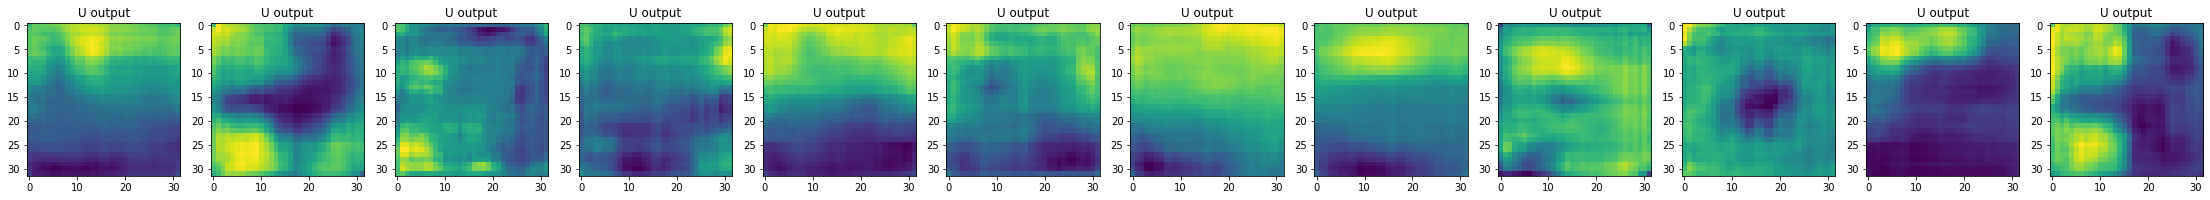

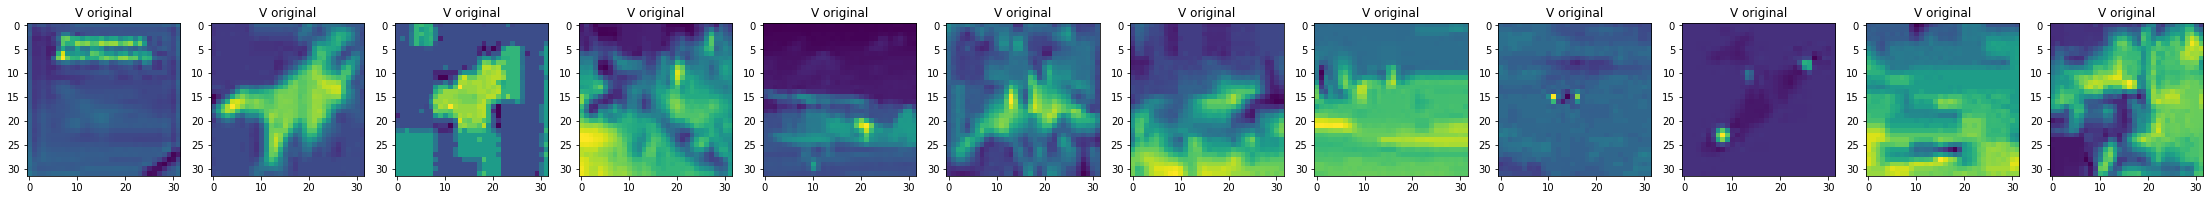

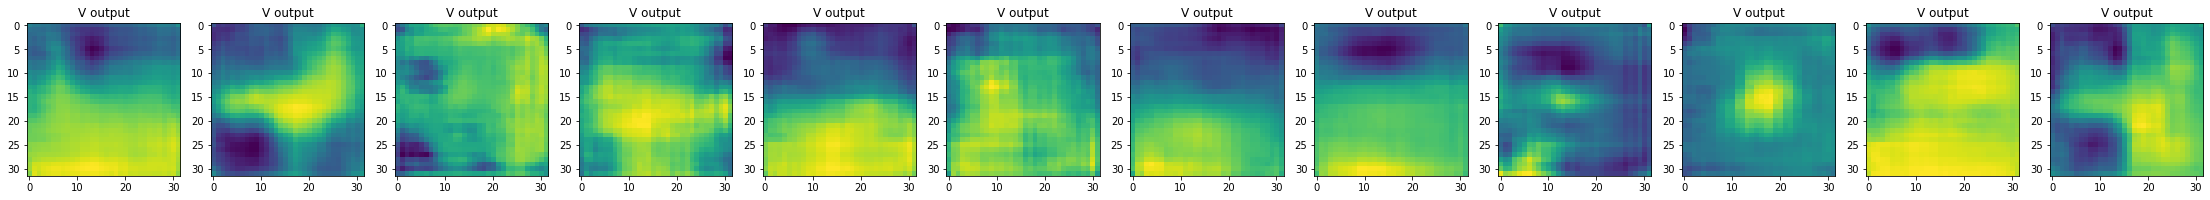

In [0]:
print(model.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = model.predict(test_y)
result = np.zeros((test_yuvImages.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_test_images[TEST_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])

# Layers activation visualization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


RuntimeError: ignored

<Figure size 648x0 with 1 Axes>

RuntimeError: ignored

<Figure size 648x0 with 1 Axes>

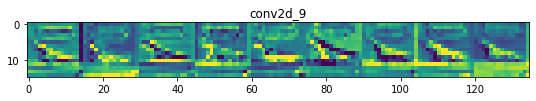

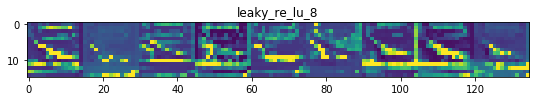

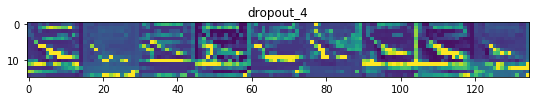

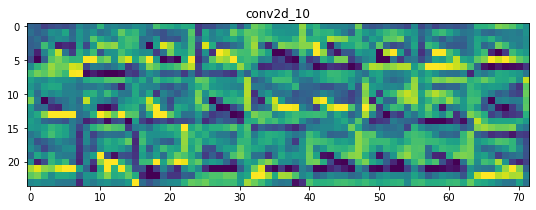

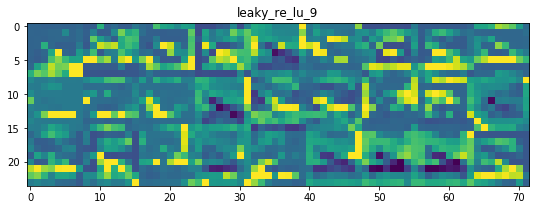

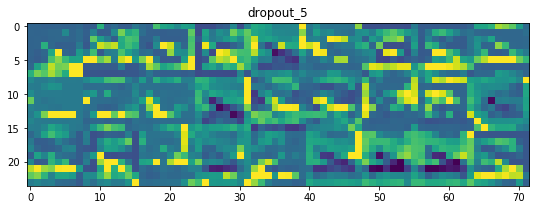

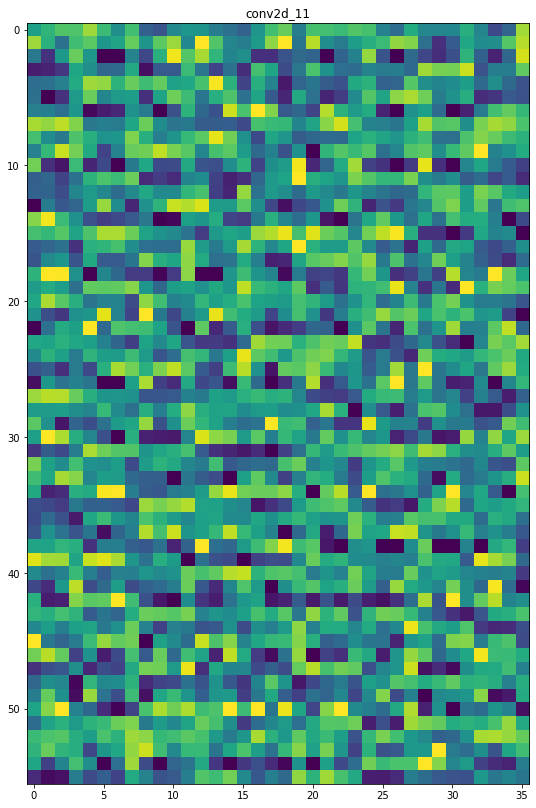

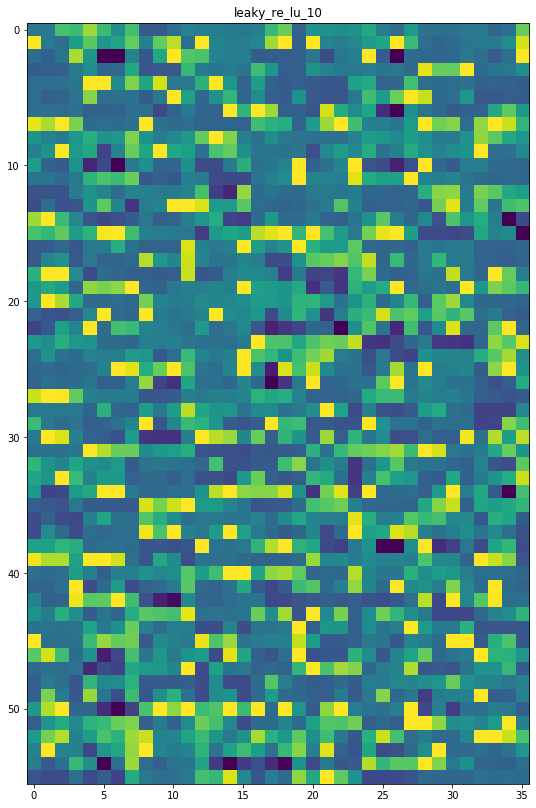

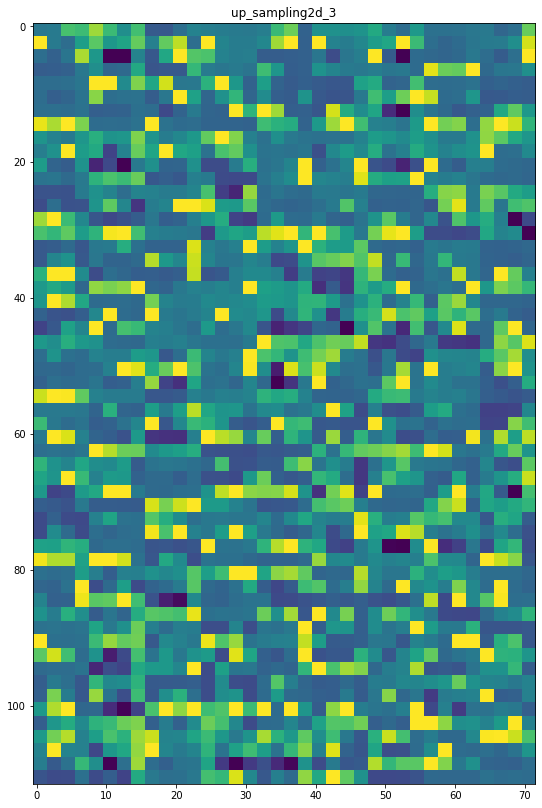

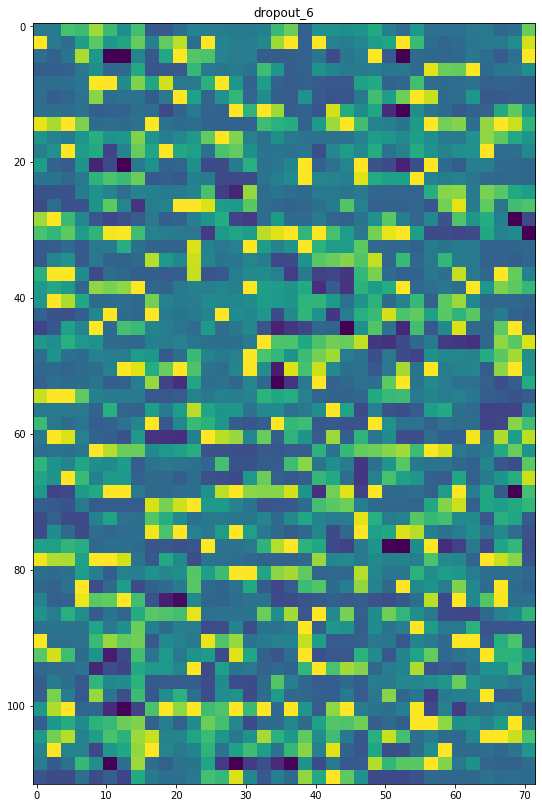

In [0]:
#https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(test_y) # Returns a list of five Numpy arrays: one array per layer activation

layer_names = []
for layer in model.layers[:12]:
  layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 9

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :,col * images_per_row + row]
      channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')